# <a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science</a>
# <a href=https://ramp.r0h.eu/problems/air_passengers>RAMP</a> on predicting the number of air passengers

<i> Balázs Kégl (LAL/CNRS), Alex Gramfort (LTCI/Telecom ParisTech), Djalel Benbouzid (UPMC), Mehdi Cherti (LAL/CNRS) </i>

## Introduction
The data set was donated to us by an unnamed company handling flight ticket reservations. The data is thin, it contains
<ul>
<li> the date of departure
<li> the departure airport
<li> the arrival airport
<li> the mean and standard deviation of the number of weeks of the reservations made before the departure date
<li> a field called <code>log_PAX</code> which is related to the number of passengers (the actual number were changed for privacy reasons)
</ul>

The goal is to predict the <code>log_PAX</code> column. The prediction quality is measured by RMSE. 

The data is obviously limited, but since data and location informations are available, it can be joined to external data sets. <b>The challenge in this RAMP is to find good data that can be correlated to flight traffic</b>.

In [11]:
%matplotlib inline
import imp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
import datetime
import warnings
warnings.filterwarnings("ignore")

In [203]:
problem = imp.load_source('', 'problem.py')

### Analyse de base

In [233]:
def transStarting(X):
    
    X_encoded = X.copy()

    df = pd.read_csv("submissions/starting_kit/external_data.csv")
    
    distanceDF = pd.DataFrame()
    distanceDF = df[['Departure','Arrival','Distance']] 
    distanceDF.dropna(inplace = True)
    distanceDF.reset_index(inplace=True,drop= True)
    dataEXT = df.drop(['Departure','Arrival','Distance'], axis=1)
    dataEXT.dropna(how='all',inplace=True)
    X_encoded = X_encoded.merge(distanceDF,how="left", on=['Departure', 'Arrival'])
    X_encoded= X_encoded.merge(dataEXT,how="left", left_on=['DateOfDeparture','Departure'], right_on=['Date','AirPort'],
                               suffixes=('','_d'))
    X_encoded= X_encoded.merge(dataEXT,how="left", left_on=['DateOfDeparture','Arrival'], right_on=['Date','AirPort'],
                               suffixes=('','_a'))

    X_encoded= X_encoded.drop(['Date','AirPort', 'City','City_a','Date_a','AirPort_a','N_BD_a','Oil_Poffset1_a','Oil_Poffset12_a',
                               'Oil_Poffset3_a','Oil_Poffset6_a'],axis=1)
    X_encoded['Mean Humidity']=X_encoded['Mean Humidity']-X_encoded['Mean Humidity_a']
    X_encoded['Population']=X_encoded['Population']-X_encoded['Population_a']
    X_encoded['Mean TemperatureC']=X_encoded['Mean TemperatureC']-X_encoded['Mean TemperatureC_a']
    X_encoded['Mean Sea Level PressurehPa']=X_encoded['Mean Sea Level PressurehPa']-X_encoded['Mean Sea Level PressurehPa_a']
    X_encoded['Dew PointC_a']=X_encoded['Dew PointC']-X_encoded['Dew PointC_a']
    X_encoded['Mean VisibilityKm']=X_encoded['Mean VisibilityKm']-X_encoded['Mean VisibilityKm_a']
    X_encoded['Mean Wind SpeedKm/h']=X_encoded['Mean Wind SpeedKm/h']-X_encoded['Mean Wind SpeedKm/h_a']
    X_encoded['MeanDew PointC']=X_encoded['MeanDew PointC']-X_encoded['MeanDew PointC_a']
    X_encoded['WindDirDegrees']=X_encoded['WindDirDegrees']-X_encoded['WindDirDegrees_a']
    #X_encoded['CloudCover']=X_encoded['CloudCover']-X_encoded['CloudCover_a']
    X_encoded = X_encoded.drop('Mean Humidity_a', axis=1)
    X_encoded = X_encoded.drop('Population_a', axis=1)
    X_encoded = X_encoded.drop('Mean TemperatureC_a', axis=1)
    X_encoded = X_encoded.drop('Mean Sea Level PressurehPa_a', axis=1)
    X_encoded = X_encoded.drop('Mean VisibilityKm_a', axis=1)
    X_encoded = X_encoded.drop('Mean Wind SpeedKm/h_a', axis=1)
    X_encoded = X_encoded.drop('MeanDew PointC_a', axis=1)
    X_encoded = X_encoded.drop('WindDirDegrees_a', axis=1)
    X_encoded = X_encoded.drop('Dew PointC', axis=1)
    X_encoded = X_encoded.drop('Dew PointC_a', axis=1) 
    X_encoded = X_encoded.drop(['CloudCover_a','CloudCover'], axis=1)
    
    X_encoded['DateOfDeparture']=pd.to_datetime(X_encoded['DateOfDeparture'], format='%Y-%m-%d')

    X_encoded['DateOfDeparture'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("2000-01-01")).days)
    convert_dict = {'Mean Humidity': int, 
                    'N_BD': int,
                    'Mean Sea Level PressurehPa': int,
                    'Mean TemperatureC': int,
                    'Mean VisibilityKm': int,
                    'Mean Wind SpeedKm/h': int,
                    'WindDirDegrees': int,
                    'MeanDew PointC':int
                   } 
    X_encoded = X_encoded.astype(convert_dict) 

    X_encoded = X_encoded.drop('Departure', axis=1)
    X_encoded = X_encoded.drop('Arrival', axis=1)
    
    return X_encoded

In [234]:
X_train, y_train = problem.get_train_data()
X_train = transStarting(X_train)

In [236]:
data = X_train.copy()
data['Y'] = y_train

Text(0, 0.5, 'Prix')

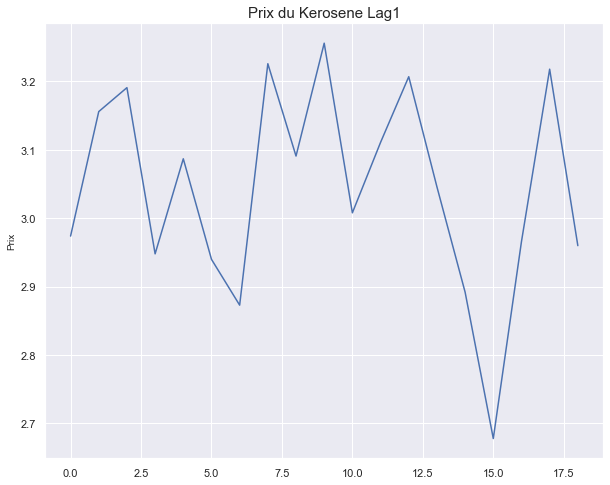

In [238]:
plt.figure(figsize = (10,8))
plt.title('Prix du Kerosene Lag1',fontsize = 15)
plt.plot(data.Oil_Poffset1.unique())
plt.ylabel('Prix',fontsize=10)

Text(0, 0.5, 'Prix')

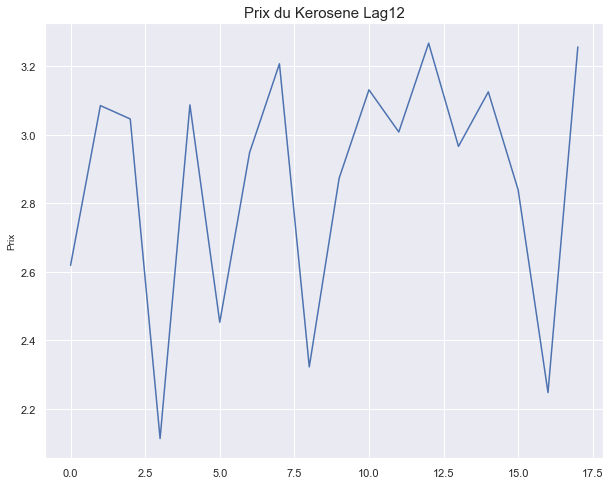

In [237]:
plt.figure(figsize = (10,8))
plt.title('Prix du Kerosene Lag12',fontsize = 15)
plt.plot(data.Oil_Poffset12.unique())
plt.ylabel('Prix',fontsize=10)

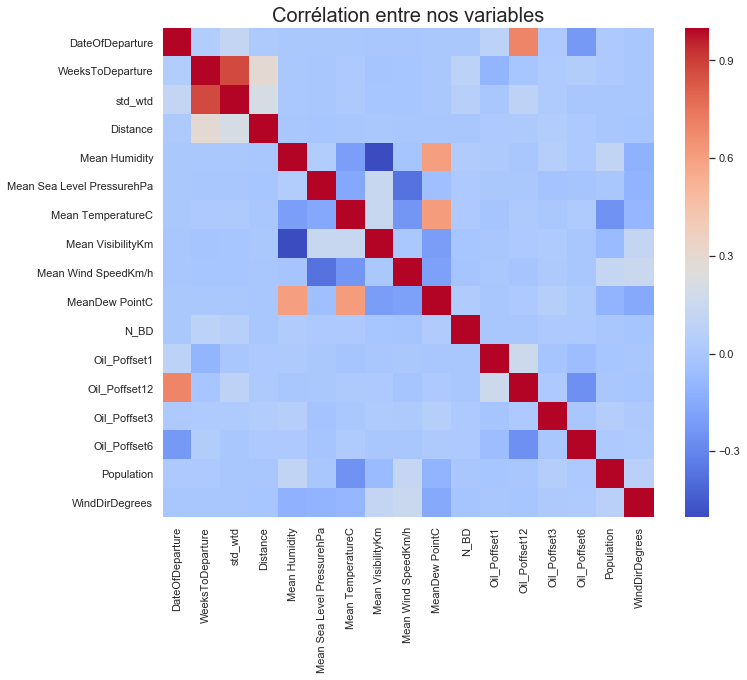

In [239]:
plt.figure(figsize=(11,9))
cor = X_train.corr()
sns.heatmap(cor, cmap='coolwarm')
plt.title("Corrélation entre nos variables", fontsize= 20)
plt.show()

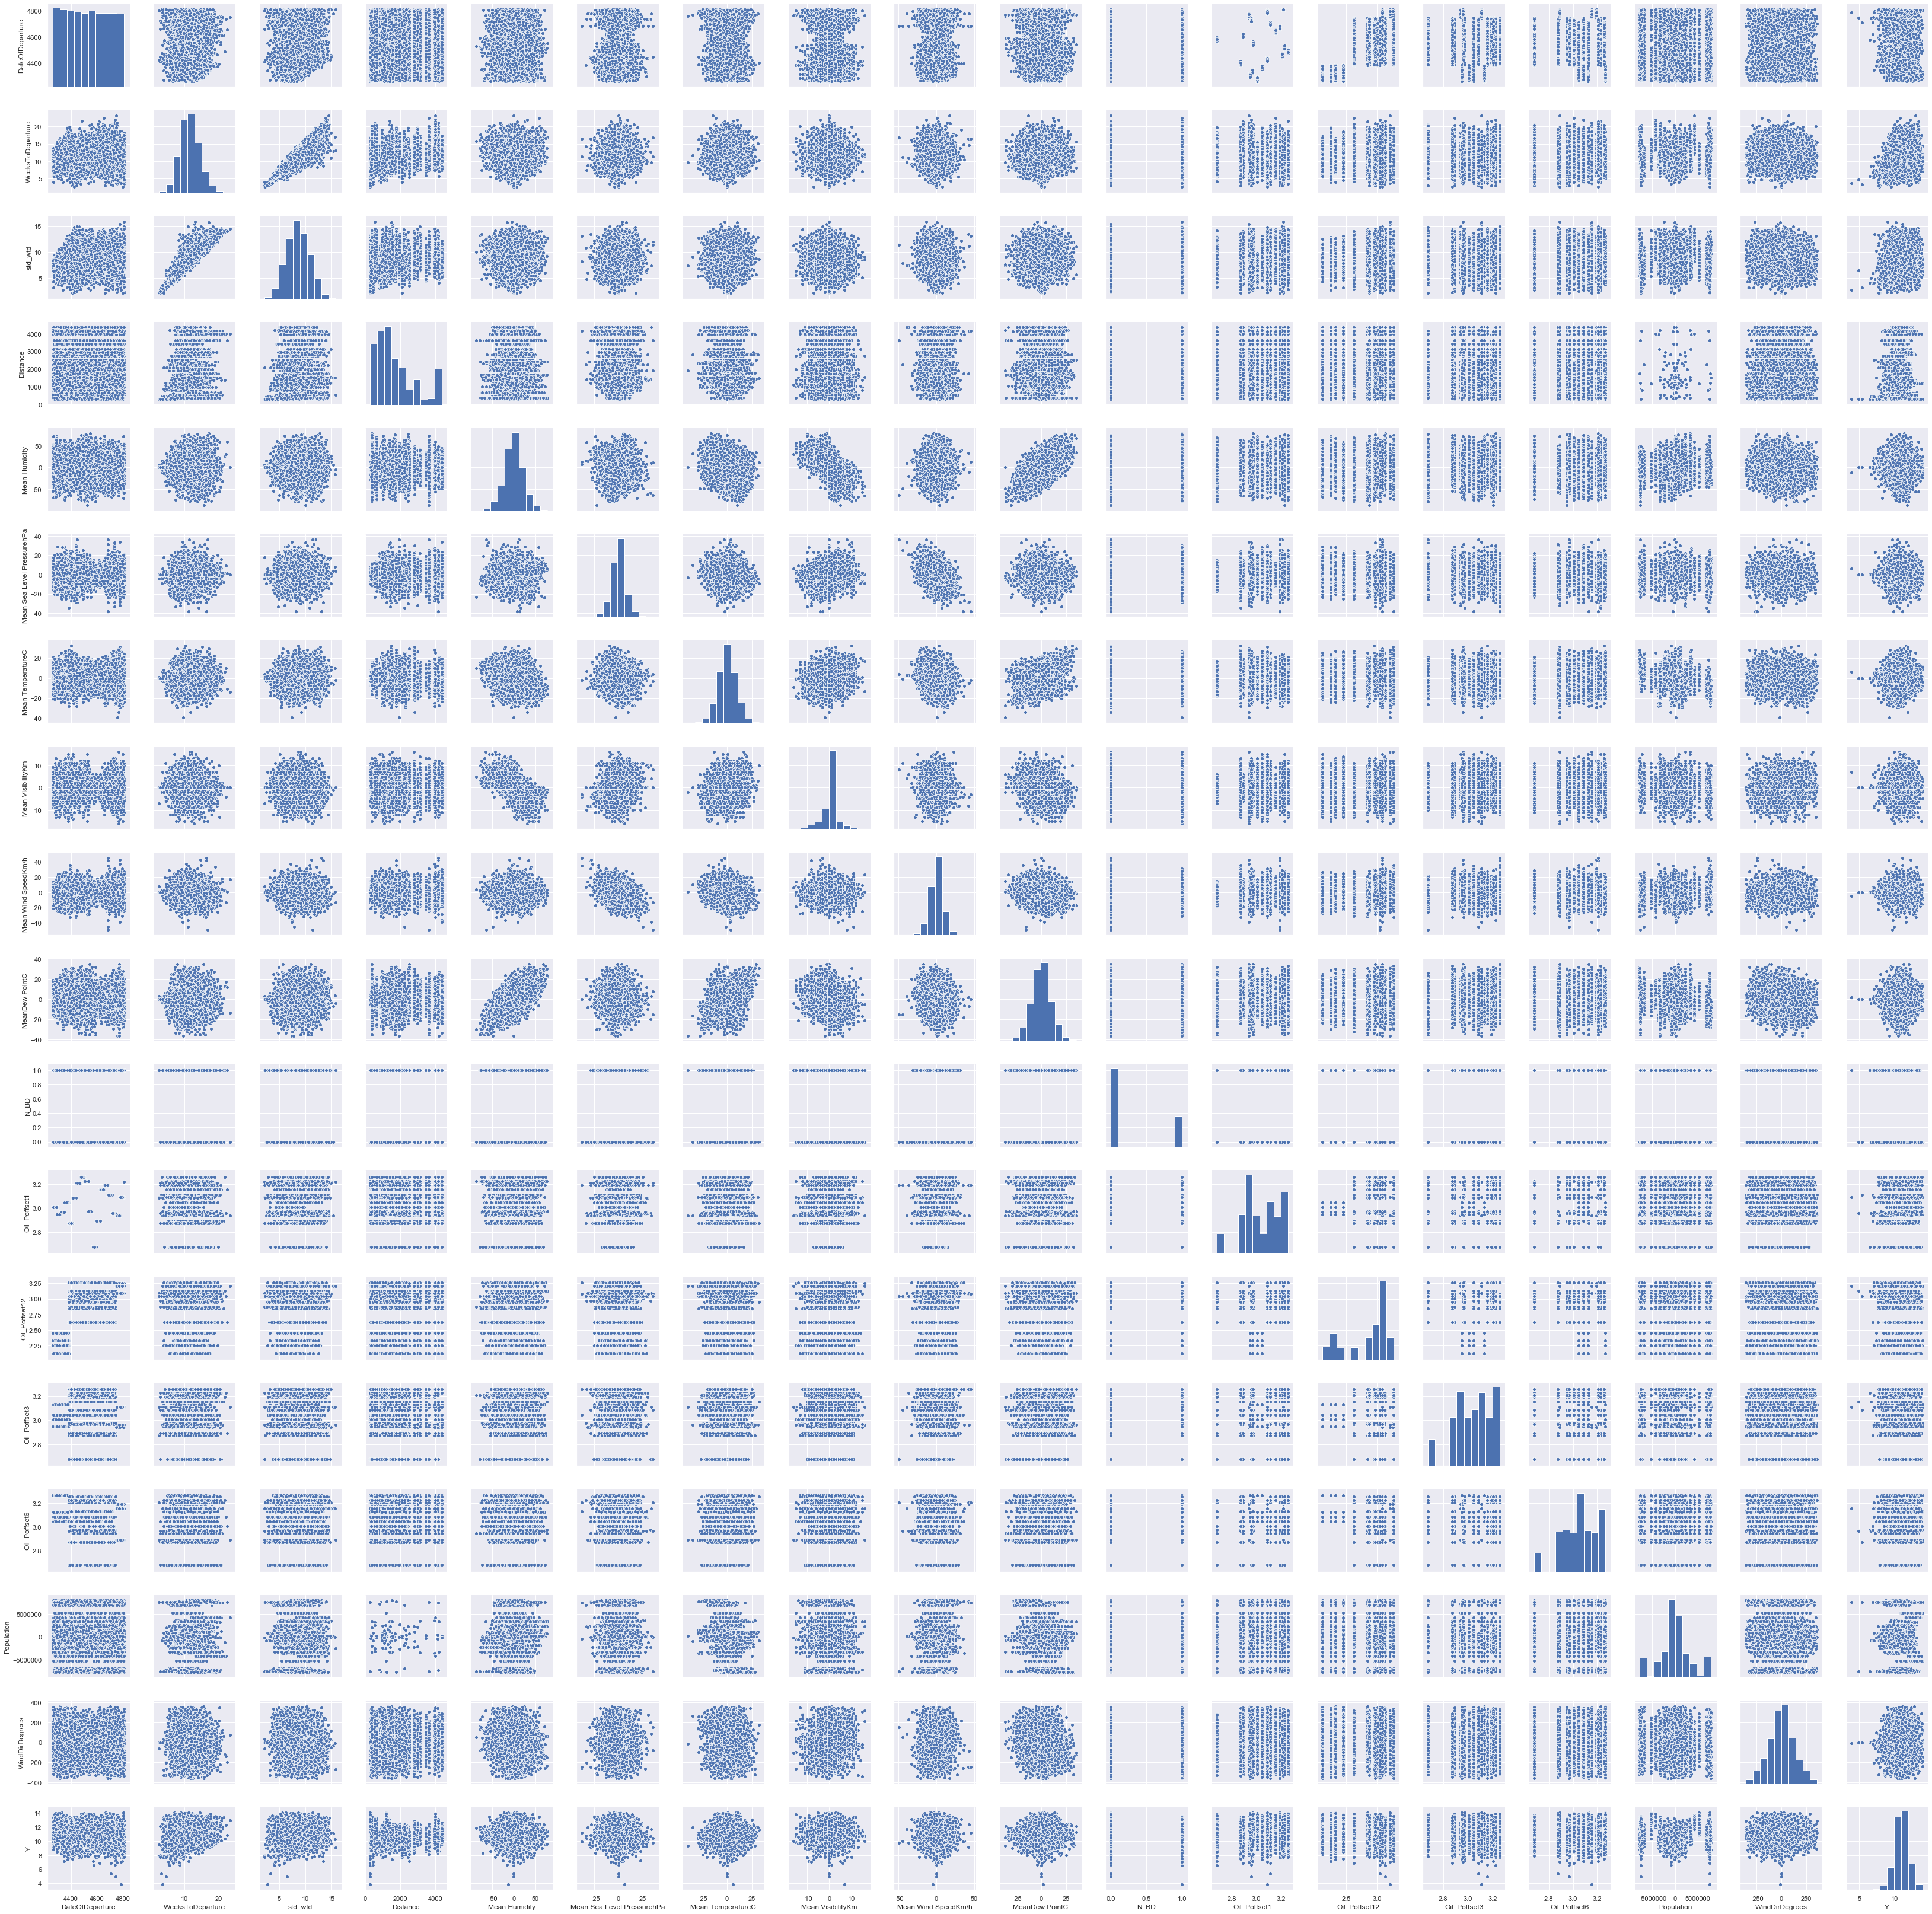

In [240]:
sns.pairplot(data)

### Preprocessing

In [204]:
def trans(X):
    
    X_encoded = X.copy()

    df = pd.read_csv("submissions/starting_kit/external_data.csv")
    
    distanceDF = pd.DataFrame()
    distanceDF = df[['Departure','Arrival','Distance']] 
    distanceDF.dropna(inplace = True)
    distanceDF.reset_index(inplace=True,drop= True)
    dataEXT = df.drop(['Departure','Arrival','Distance'], axis=1)
    dataEXT.dropna(how='all',inplace=True)
    X_encoded = X_encoded.merge(distanceDF,how="left", on=['Departure', 'Arrival'])
    X_encoded= X_encoded.merge(dataEXT,how="left", left_on=['DateOfDeparture','Departure'], right_on=['Date','AirPort'],
                               suffixes=('','_d'))
    X_encoded= X_encoded.merge(dataEXT,how="left", left_on=['DateOfDeparture','Arrival'], right_on=['Date','AirPort'],
                               suffixes=('','_a'))

    X_encoded= X_encoded.drop(['Date','AirPort', 'City','City_a','Date_a','AirPort_a','N_BD_a','Oil_Poffset1_a','Oil_Poffset12_a',
                               'Oil_Poffset3_a','Oil_Poffset6_a'],axis=1)
    X_encoded['Mean Humidity']=X_encoded['Mean Humidity']-X_encoded['Mean Humidity_a']
    X_encoded['Population']=X_encoded['Population']-X_encoded['Population_a']
    X_encoded['Mean TemperatureC']=X_encoded['Mean TemperatureC']-X_encoded['Mean TemperatureC_a']
    X_encoded['Mean Sea Level PressurehPa']=X_encoded['Mean Sea Level PressurehPa']-X_encoded['Mean Sea Level PressurehPa_a']
    X_encoded['Dew PointC_a']=X_encoded['Dew PointC']-X_encoded['Dew PointC_a']
    X_encoded['Mean VisibilityKm']=X_encoded['Mean VisibilityKm']-X_encoded['Mean VisibilityKm_a']
    X_encoded['Mean Wind SpeedKm/h']=X_encoded['Mean Wind SpeedKm/h']-X_encoded['Mean Wind SpeedKm/h_a']
    X_encoded['MeanDew PointC']=X_encoded['MeanDew PointC']-X_encoded['MeanDew PointC_a']
    X_encoded['WindDirDegrees']=X_encoded['WindDirDegrees']-X_encoded['WindDirDegrees_a']
    #X_encoded['CloudCover']=X_encoded['CloudCover']-X_encoded['CloudCover_a']
    X_encoded = X_encoded.drop('Mean Humidity_a', axis=1)
    X_encoded = X_encoded.drop('Population_a', axis=1)
    X_encoded = X_encoded.drop('Mean TemperatureC_a', axis=1)
    X_encoded = X_encoded.drop('Mean Sea Level PressurehPa_a', axis=1)
    X_encoded = X_encoded.drop('Mean VisibilityKm_a', axis=1)
    X_encoded = X_encoded.drop('Mean Wind SpeedKm/h_a', axis=1)
    X_encoded = X_encoded.drop('MeanDew PointC_a', axis=1)
    X_encoded = X_encoded.drop('WindDirDegrees_a', axis=1)
    X_encoded = X_encoded.drop('Dew PointC', axis=1)
    X_encoded = X_encoded.drop('Dew PointC_a', axis=1) 
    X_encoded = X_encoded.drop(['CloudCover_a','CloudCover'], axis=1)
    
    dateValues = X_encoded.DateOfDeparture.values
    HighVolumeMonth = []
    yearValues = []
    for d in dateValues:
        m = d.split('-')[1]
    #     if m==9 or  m==10 or m==11 or m==12 or m==1 or m==2:
    #         m = 1
    #     else:
    #         m = 0
        HighVolumeMonth.append(m)
        y = d.split('-')[0]
        yearValues.append(y)
    X_encoded['DateOfDeparture']=pd.to_datetime(X_encoded['DateOfDeparture'], format='%Y-%m-%d')
    X_encoded['Month'] = HighVolumeMonth
    X_encoded['Month'] = X_encoded['Month'].astype('int')
    X_encoded['Year'] = yearValues
    X_encoded['Year'] = X_encoded['Year'].astype('int')
    X_encoded['DateOfDeparture'] = X_encoded['DateOfDeparture'].apply(lambda date: (date - pd.to_datetime("2000-01-01")).days)
    convert_dict = {'Mean Humidity': int, 
                    'N_BD': int,
                    'Mean Sea Level PressurehPa': int,
                    'Mean TemperatureC': int,
                    'Mean VisibilityKm': int,
                    'Mean Wind SpeedKm/h': int,
                    'WindDirDegrees': int,
                    'MeanDew PointC':int
                   } 
    X_encoded = X_encoded.astype(convert_dict) 
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Departure'], prefix='d'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Arrival'], prefix='a'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Month'], prefix='m'))
    X_encoded = X_encoded.join(pd.get_dummies(X_encoded['Year'], prefix='y'))
    X_encoded = X_encoded.drop('Departure', axis=1)
    X_encoded = X_encoded.drop('Arrival', axis=1)
    X_encoded = X_encoded.drop('Month', axis=1)
    X_encoded = X_encoded.drop('Year', axis=1)
    

    
    scaler = MinMaxScaler()
    columns_to_scale = ['DateOfDeparture', 'WeeksToDeparture', 'std_wtd', 'Distance',
       'Mean Humidity', 'Mean Sea Level PressurehPa', 'Mean TemperatureC',
       'Mean VisibilityKm', 'Mean Wind SpeedKm/h', 'MeanDew PointC',
       'Oil_Poffset1', 'Oil_Poffset12', 'Oil_Poffset3', 'Oil_Poffset6',
       'Population', 'WindDirDegrees']
    X_encoded[columns_to_scale] = scaler.fit_transform(X_encoded[columns_to_scale])
    ############################
#     X_encoded = X_encoded.drop('std_wtd', axis=1)
#     X_encoded = X_encoded.drop('WeeksToDeparture', axis=1)
    #############################
    return X_encoded

    

In [227]:
X_train, y_train = problem.get_train_data()
X_train = trans(X_train)
X_test, y_test = problem.get_test_data()
X_test = trans(X_test)

## Feature Selection

In [207]:
from boruta import BorutaPy
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

In [208]:
rfc = RandomForestRegressor(n_estimators = 200, max_depth=6)
boruta_selector = BorutaPy(rfc, n_estimators='auto', verbose=0, max_iter=100)

In [209]:
xtrainvalues = X_train.values
ytrainvalues = y_train
boruta_selector.fit(xtrainvalues,ytrainvalues)

BorutaPy(alpha=0.05,
         estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                         criterion='mse', max_depth=6,
                                         max_features='auto',
                                         max_leaf_nodes=None, max_samples=None,
                                         min_impurity_decrease=0.0,
                                         min_impurity_split=None,
                                         min_samples_leaf=1,
                                         min_samples_split=2,
                                         min_weight_fraction_leaf=0.0,
                                         n_estimators=97, n_jobs=None,
                                         oob_score=False,
                                         random_state=<mtrand.RandomState object at 0x000002BE90DCCDC8>,
                                         verbose=0, warm_start=False),
         max_iter=100, n_estimators='auto', perc=100,
       

In [210]:
importance_df = pd.DataFrame(X_train.columns.tolist(), columns = ['column_name'])
importance_df['feature_importance'] = boruta_selector.ranking_
importance_df = importance_df.sort_values('feature_importance', ascending = True)
importance_df.head(boruta_selector.n_features_)

column_name  feature_importance
0     DateOfDeparture                   1
1            Distance                   1
66               m_12                   1
50              a_ORD                   1
4   Mean TemperatureC                   1
45              a_LAX                   1
43              a_JFK                   1
40              a_DTW                   1
8                N_BD                   1
30              d_ORD                   1
25              d_LAX                   1
23              d_JFK                   1
13         Population                   1
20              d_DTW                   1

In [211]:
important_features = importance_df.head(boruta_selector.n_features_)['column_name'].tolist()
important_features

['DateOfDeparture',
 'Distance',
 'm_12',
 'a_ORD',
 'Mean TemperatureC',
 'a_LAX',
 'a_JFK',
 'a_DTW',
 'N_BD',
 'd_ORD',
 'd_LAX',
 'd_JFK',
 'Population',
 'd_DTW']

## Model Tuning

In [212]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator
from sklearn.model_selection import RandomizedSearchCV

#### LGBM

In [213]:
param_test ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

n_HP_points_to_test = 100

In [214]:
model = lgbm.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='neg_root_mean_squared_error', n_jobs=4, n_estimators=5000)
searchLGB = RandomizedSearchCV(estimator = model, scoring = 'neg_root_mean_squared_error',
                              param_distributions = param_test,
                              n_iter=n_HP_points_to_test,
                              cv=3,
                              refit=True,
                              random_state=314,
                              verbose=True)
searchLGB.fit(X_train[important_features],y_train)
y_pred = searchLGB.predict(X_test[important_features])
rmse = mean_squared_error(y_test,y_pred)
rmse

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:  7.0min finished


0.24306981153144241

In [229]:
print('RMSE avec LGBM: '+str(rmse))

RMSE avec LGBM: 0.24306981153144241


In [215]:
searchLGB.best_params_

{'colsample_bytree': 0.55607546409401,
 'min_child_samples': 103,
 'min_child_weight': 10.0,
 'num_leaves': 22,
 'reg_alpha': 2,
 'reg_lambda': 1,
 'subsample': 0.8939112927620336}

#### XGB

In [217]:
param_XGBR = {'learning_rate' : [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
                         'max_depth': [3, 5, 6, 7, 8, 9, 10],
                         'min_child_weight': [1, 3, 5, 7],
                         'gamma': [0 , 0.1, 0.2, 0.3, 0.4],
                         'colsample_bytree': [0.3, 0.4, 0.5, 0.7, 0.9],
                         'n_estimators':[10,25,50,100,200,300,400,500]}

modelXGB = XGBRegressor(random_state=42)

searchXGB = RandomizedSearchCV(estimator = modelXGB, scoring = 'neg_root_mean_squared_error',
                             param_distributions = param_XGBR,
                             cv = 5, n_iter=150, random_state = 42,verbose=0)
searchXGB.fit(X_train[important_features],y_train)
y_predXGB = searchXGB.predict(X_test[important_features])
rmseXGB = mean_squared_error(y_test,y_predXGB)
rmseXGB

[16:45:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:45:10] WARNI

0.1623569581826509

In [230]:
print('RMSE avec XGB & Feature Selection: '+str(rmseXGB))

RMSE avec XGBM & Feature Selection: 0.1623569581826509


In [218]:
searchXGB.best_params_

{'n_estimators': 300,
 'min_child_weight': 5,
 'max_depth': 10,
 'learning_rate': 0.2,
 'gamma': 0.1,
 'colsample_bytree': 0.4}

### XGB withoutFeature Selection

In [219]:
modelXGBAll = XGBRegressor(random_state=42)

searchXGBAll = RandomizedSearchCV(estimator = modelXGB, scoring = 'neg_root_mean_squared_error',
                             param_distributions = param_XGBR,
                             cv = 5, n_iter=150, random_state = 42,verbose=0)
searchXGBAll.fit(X_train,y_train)
y_predXGBAll = searchXGBAll.predict(X_test)
rmseXGBAll = mean_squared_error(y_test,y_predXGBAll)
rmseXGBAll

[17:01:32] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:36] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:37] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:01:45] WARNI

0.20449279172801801

In [232]:
print('RMSE avec XGB sans Feature Selection: '+str(rmseXGBAll))

RMSE avec XGB sans Feature Selection: 0.20449279172801801


In [220]:
searchXGBAll.best_params_

{'n_estimators': 400,
 'min_child_weight': 5,
 'max_depth': 8,
 'learning_rate': 0.075,
 'gamma': 0.1,
 'colsample_bytree': 0.4}

- Vous bien voir la difference entre le RAMP et nos modeles, normalement, on devrait avoir les memes score et on n'arrivent pas a trouver c'est ou le probleme. 

## Local testing (before submission)

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. For this we provide a unit test. Note that the test runs on your files in [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit).

First `pip install ramp-workflow` or install it from the [github repo](https://github.com/paris-saclay-cds/ramp-workflow). Make sure that the python files `feature_extractor.py`, `regressor.py`, and `external_data.csv` are in the  [`submissions/starting_kit`](http://localhost:8890/tree/submissions/starting_kit) folder, and the data `train.csv.bz2` and `test.csv.bz2` are in [`data`](http://localhost:8890/tree/data). Then run

```ramp_test_submission```

If it runs and print training and test errors on each fold, then you can submit the code.

In [223]:
!ramp_test_submission

Testing Number of air passengers prediction
Reading train and test files from ./data ...
Reading cv ...
Training submissions\starting_kit ...
CV fold 0
[18:10:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	score   rmse      time
	train  0.167  5.889542
	valid  0.485  1.615575
	test   0.522  0.485702
CV fold 1
[18:10:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	score   rmse      time
	train  0.173  5.655332
	valid  0.494  1.571522
	test   0.508  0.466153
CV fold 2
[18:10:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	score   rmse      time
	train  0.166  5.745702
	valid  0.488  1.575526
	test   0.520  0.472504
CV fold 3
[18:10:29] WARNING: C:/Jenkins/workspa

Alternatively, load and execute `rampwf.utils.testing.py`, and call `assert_submission`. This may be useful if you would like to understand how we instantiate the workflow, the scores, the data connectors, and the cross validation scheme defined in [`problem.py`](problem.py), and how we insert and train/test your submission.